## Generate latent dynamics for Von Mises brain

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
from VonMisesFunctions import *
from plotutils import *

### Create graphical model

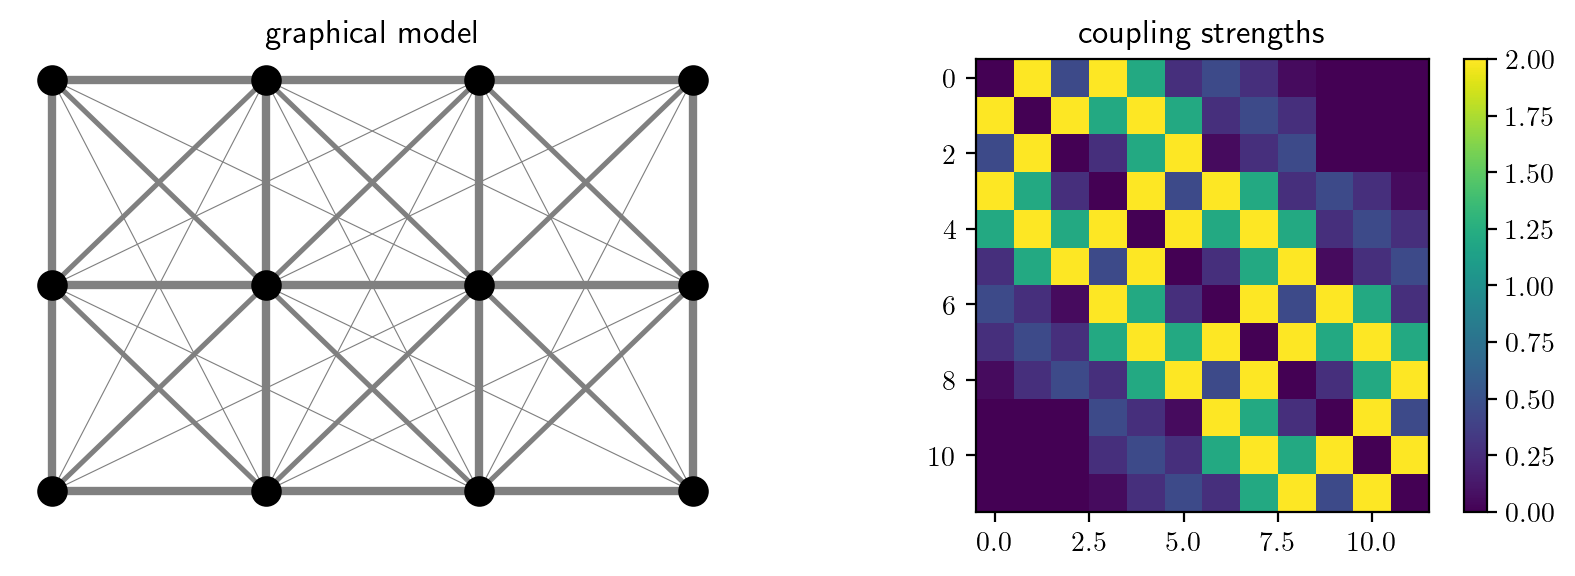

In [2]:
# create a grid structured graphical model
nrows, ncols = 3, 4
Ns = nrows*ncols # No. of variables

c_spatial, c_strength, jitter =  2, 2, 0 # singleton potential strength, pairwise coupling spatial scale, max interaction strength, jitter in coupling strength
J, node_positions = CreateGridGraphicalModel(ncols, nrows, c_spatial, c_strength, jitter)

AdjMat = (J[...,3] != 0)*1 # Adjacency matrix

DisplayGraphicalModel(J, node_positions,100)

### Generate input signal

Generate local orientation input at each node $\mu_s(t) \in [-\pi/2,\pi/2)$

In [3]:
B, T = 50, 30 # no. of batches, no. of time steps
T_low, T_high = 5, 10 # range of T_const = np. of time steps for which input is held constant

Mu = GenerateDynamicMu(Ns, B, T-1, T_low, T_high)

kappa_low  = 1 # baseline value of concentration parameters
kappa_high = 2 # factor by which to scale gamma distribtuion used to generate K 
Kappa = GenerateDynamicK(Ns, B, T-1, T_low, T_high, kappa_low, kappa_high)

### Generate BP dynamics

In [4]:
N   = 31    # no. of discrete bins used to represent the belief of each variable
lam = 0.25  # relaxation parameter for BP dynamics

local_inputs, beliefs = [], []

for b in tqdm(range(B)):
    Phi = DiscreteSingletonPotentials(N, Kappa[b], Mu[b])
    Psi = DiscretePairwisePotentials(N, Mu[b], J)
    local_inputs.append(Phi)
    beliefs.append(DiscreteBP(Phi, Psi, AdjMat, T, lam, None)[1])
    
    
local_inputs = np.array(local_inputs)
local_inputs = local_inputs/np.sum(local_inputs[:,:,:,None,:],axis=2) # normalize local potentials
beliefs = np.array(beliefs)

100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


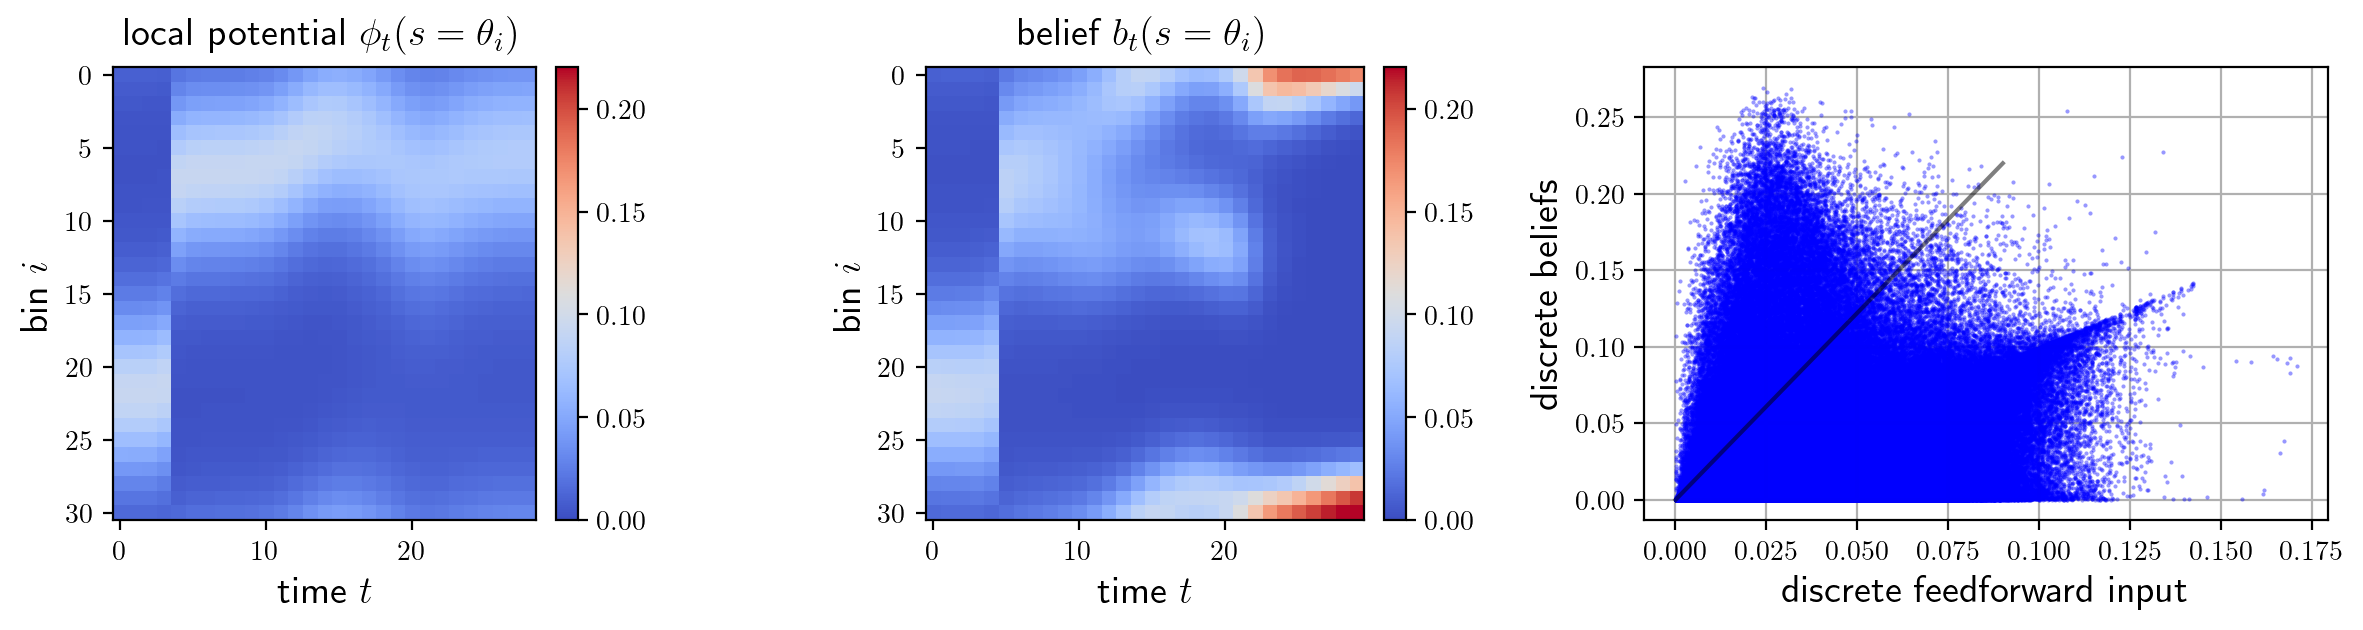

In [5]:
var, b = 5, 7
DisplayBeliefDynamics(var, b, local_inputs, beliefs)

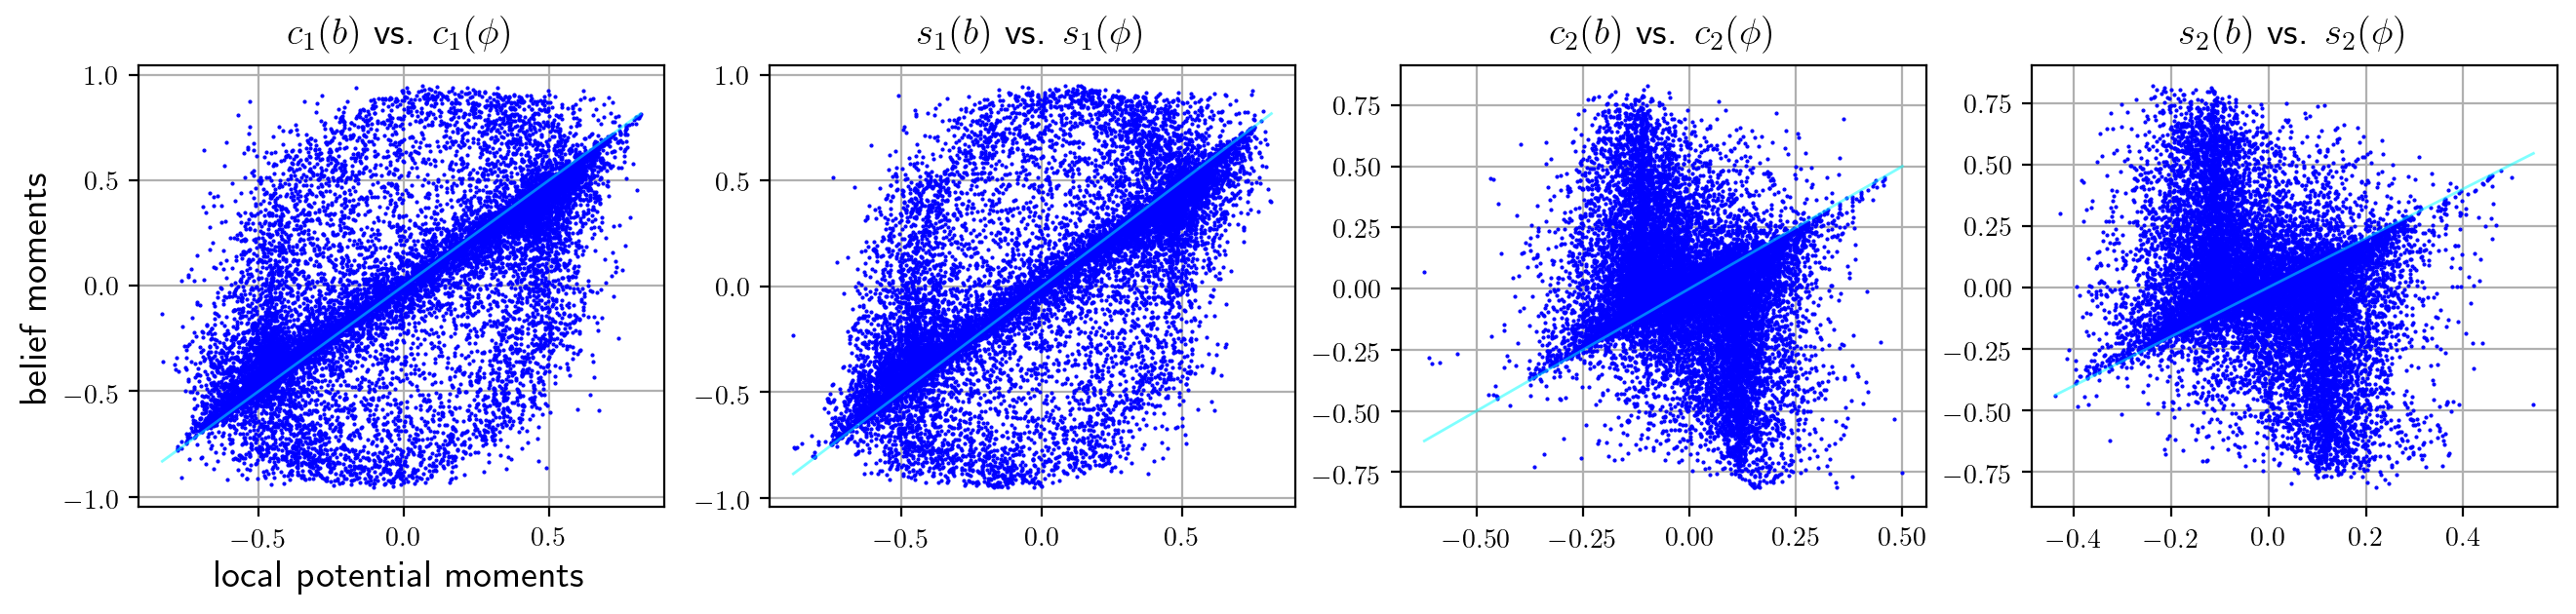

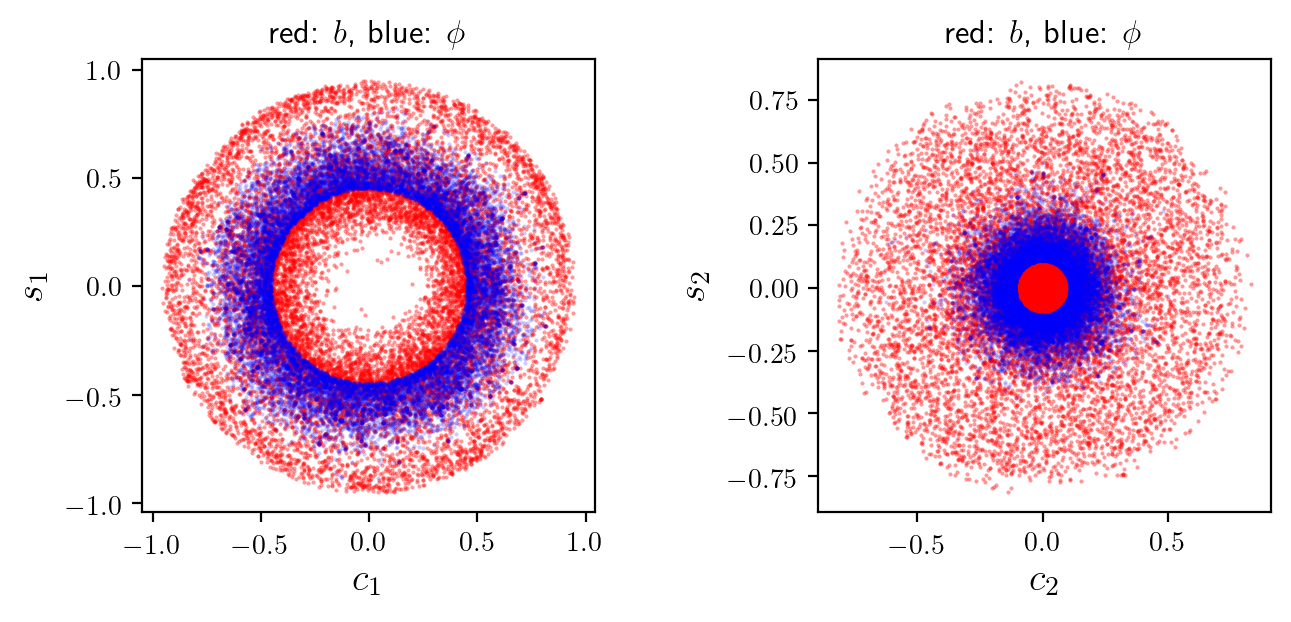

In [6]:
# Compute circular moments
l_cos2x, l_sin2x, l_cos4x, l_sin4x = ComputeCircularMoments(local_inputs, N)
b_cos2x, b_sin2x, b_cos4x, b_sin4x = ComputeCircularMoments(beliefs, N)

# Scatter plots of circular moments
DisplayCircularMoments1(local_inputs, beliefs, N)
DisplayCircularMoments2(local_inputs, beliefs, N)